In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from aim_perception.loading import AimDatasetConstructor

In [2]:
root_dir = '/home/ubuntu/aim/vehicle_dataset'

# Observe Class Distribution

In [3]:
# Load ground truth df
df = pd.read_csv(os.path.join(root_dir, 'ground_truth.csv'), names=['image_name', 'class'], dtype=str)

In [4]:
# Get counts
df1 = df.groupby('class').count().image_name.rename('class_count').reset_index()
df1

,class,class_count
0,articulated_truck,8277
1,bicycle,1827
2,bus,8253
3,car,30000
4,motorcycle,1586
5,non-motorized_vehicle,1401
6,pedestrian,5010
7,pickup_truck,15000
8,single_unit_truck,4096
9,work_van,7743


In [5]:
df1['percentage'] = round(df1.class_count / len(df) * 100, 2)
df1

,class,class_count,percentage
0,articulated_truck,8277,9.95
1,bicycle,1827,2.20
2,bus,8253,9.92
3,car,30000,36.06
4,motorcycle,1586,1.91
5,non-motorized_vehicle,1401,1.68
6,pedestrian,5010,6.02
7,pickup_truck,15000,18.03
8,single_unit_truck,4096,4.92
9,work_van,7743,9.31


We observe a heavy class imbalance. This can result in poor model perforrmance. We will therefore use class weights in the criterion during model training.

## Image Size
Observe the distribution of image sizes to identify optimal size for resizing.

We only use the training set, as a means to avoid leaking information into the data augmentation.

In [6]:
dataset_constructor = AimDatasetConstructor(
    root_dir=root_dir, 
    csv_path='ground_truth.csv',
    data_subdir='data', 
    transforms=[]
)

Train percent: 75.00150253026095
Val percent: 14.99885807700167
Test percent: 9.99963939273737


In [7]:
# Load heights and widths
dataset = dataset_constructor.get_train()

w, h = [], []
for image, _ in dataset:
    array = np.array(image)

    h.append(array.shape[0])
    w.append(array.shape[1])

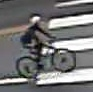

In [8]:
image

Mdian hieght: 90.0


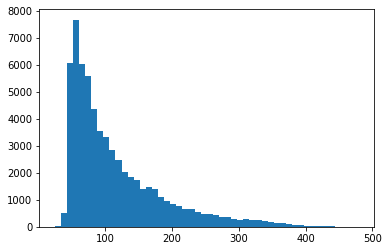

In [9]:
# Observe height distribution
plt.hist(h, bins=50)
print(f'Mdian hieght: {np.median(h)}')

Mdian hieght: 121.0


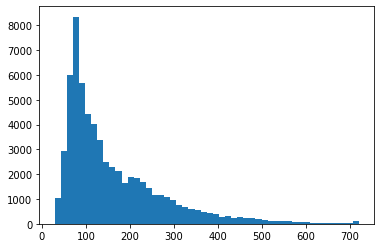

In [10]:
# Observe width distribution
plt.hist(w, bins=50)
print(f'Mdian hieght: {np.median(w)}')

We observe the median height to be 90, the median width to be 121.

We want to optimize the resizing to perturb the data as little as possible. Thus, we will use an image size of 126 for training.

## Channel Distribution
We will load the torch tensors with the image resize to find the mean and standard deviation across dims.

We only use the training set, as a means to avoid leaking information into the data augmentation.

In [11]:
image_size = (126, 126)
img_transforms = [            
    transforms.ToTensor(),
    transforms.Resize(size=image_size),
]

dis_constructor = AimDatasetConstructor(
    root_dir=root_dir, 
    csv_path='ground_truth.csv',
    data_subdir='data', 
    transforms=img_transforms
)

train_dist_dataset = dis_constructor.get_train()

Train percent: 75.00150253026095
Val percent: 14.99885807700167
Test percent: 9.99963939273737


In [12]:
tensors = torch.stack([i for i, _ in train_dist_dataset])

In [ ]:
mean = tensors.mean(axis=(0, 2, 3))
std = tensors.std(axis=(0, 2, 3))

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.4876, 0.4846, 0.4841])
Std: tensor([0.2448, 0.2435, 0.2481])
